In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
#downloading and loading the training and testing sets

# image is of form PILImage of range [0,1]. we transform to normalized range[-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car',  'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


(3, 36, 138)


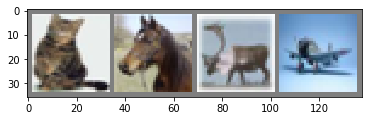

  cat horse  deer plane


In [18]:
#displaying the pics from the training data

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize [-1,1] -> [0,1]
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [22]:
#Define a CNN

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


In [24]:
#checking the parameters in the NN

for x in net.parameters():
    print(x.size())2

torch.Size([6, 3, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


In [25]:
#define the loss function and optimizer

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [29]:
#train the network

for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        #get the unputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        #zero the param gradients
        optimizer.zero_grad()
        
        #forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i+1, running_loss/2000))
            running_loss = 0.0
            
print('Finished Training')

[1,  2000] loss: 2.093
[1,  4000] loss: 1.940
[1,  6000] loss: 1.950
[1,  8000] loss: 1.950
[1, 10000] loss: 1.949
[1, 12000] loss: 1.963
[2,  2000] loss: 1.978
[2,  4000] loss: 1.980
[2,  6000] loss: 1.968
[2,  8000] loss: 1.978
[2, 10000] loss: 1.999
[2, 12000] loss: 1.992
Finished Training


(3, 36, 138)


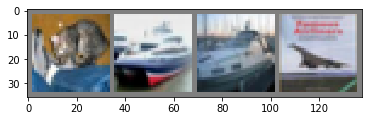

GroundTruth:    cat  ship  ship plane


In [30]:
#test the network on the test data

dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [32]:
#predicting 

output = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(4)))

Predicted:   bird  ship   car   car


In [33]:
# predicting over whole dataset

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 24 %


In [34]:
# finding the classes which did and did not perform well

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane :  9 %
Accuracy of   car : 37 %
Accuracy of  bird : 13 %
Accuracy of   cat :  5 %
Accuracy of  deer :  0 %
Accuracy of   dog : 35 %
Accuracy of  frog : 62 %
Accuracy of horse :  7 %
Accuracy of  ship : 49 %
Accuracy of truck : 25 %
